In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation 
import time
import scipy as sp
import pyamg
from tqdm.notebook import tqdm

# 有限差分法

## 一维常系数对流方程
$$
\frac{\partial u}{\partial t}+c \frac{\partial u}{\partial x}=0
$$
$$
\frac{u_i^{n+1}-u_i^n}{\Delta t}+c \frac{u_i^n-u_{i-1}^n}{\Delta x}=0
$$

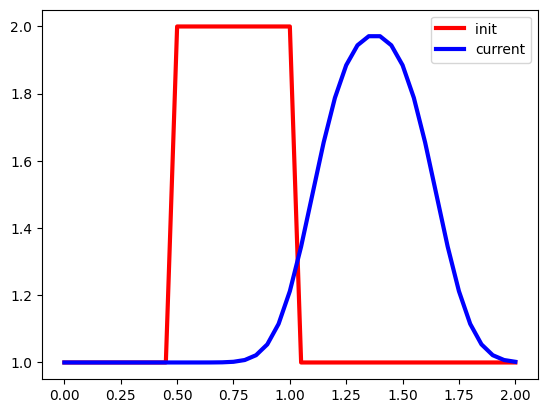

In [1]:
import numpy as np
import matplotlib.pyplot as plt
nx = 41 #×方向网格节点数量
dx =2/ (nx-1)#空间网格步长，x方向总长度2
nt =25 #时间步数
dt = 0.025 #时间步长
c = 1 #常数
#指定初始条件
u =np.ones(nx)
u[int(0.5/dx) :int(1/dx + 1)] = 2 #这一行制造了一个测试用的方波#下面将初始条件画出来
plt.plot(np.linspace(0,2,nx) ,u,'r',lw=3, label = 'init ')

#计算25个时间步后的波形
un =np.ones (nx)
for n in range (nt) :
    un = u.copy()#后面的计算会改变u，所以将u拷贝一份
    for i in range (1 ,nx):
        u[i] = un[i] - c * dt / dx *(un[i] - un[i-1])
        
plt.plot (np.linspace (0,2,nx) , u,'b',lw=3,label='current')
plt.legend ()
plt.show()


## 一维非线性对流方程
$$
\frac{\partial u}{\partial t}+u \frac{\partial u}{\partial x}=0
$$
$$
\frac{u_i^{n+1}-u_i^n}{\Delta t}+u_i^n \frac{u_i^n-u_{i-1}^n}{\Delta x}=0
$$

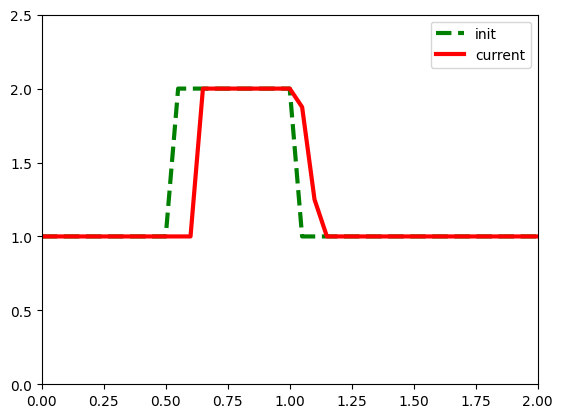

In [4]:
# 复制到py中运行没有控制Courant数
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

nx = 41  # 空间网格数
dx = 2 / (nx - 1)  # 空间网格尺寸
nt = 20  # 时间步数
dt = 0.025  # 时间步长
u = np.ones(nx)
u[int(0.6 / dx):int(1 / dx + 1)] = 2
u_init = u.copy()

fig, ax = plt.subplots()
ax.set_xlim(0, 2)
ax.set_ylim(0, 2.5)
line, = ax.plot(np.linspace(0, 2, nx), u_init, 'g--', lw=3, label='init')
line2, = ax.plot(np.linspace(0, 2, nx), u, 'r', lw=3, label='current')
ax.legend()

def update(frame):
    global u
    un = u.copy()
    for i in range(1, nx):
        u[i] = un[i] - un[i] * dt / dx * (un[i] - un[i - 1])
    line.set_ydata(u_init)  # 更新初始波形
    line2.set_ydata(u)
    return line, line2

ani = FuncAnimation(fig, update, frames=nt, blit=True, interval=200)
plt.show()

使用Courant数来确保计算稳定

In [ ]:
# 控制Courant数 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

nx = 41  # 空间网格数
dx = 2 / (nx - 1)  # 空间网格尺寸
nt = 20  # 时间步数
# dt = 0.025  # 时间步长
sigma = 0.5
dt = sigma * dx
u = np.ones(nx)
u[int(0.6 / dx):int(1 / dx + 1)] = 2
u_init = u.copy()

fig, ax = plt.subplots()
ax.set_xlim(0, 2)
ax.set_ylim(0, 2.5)
line, = ax.plot(np.linspace(0, 2, nx), u_init, 'g--', lw=3, label='init')
line2, = ax.plot(np.linspace(0, 2, nx), u, 'r', lw=3, label='current')
ax.legend()

def update(frame):
    global u
    un = u.copy()
    for i in range(1, nx):
        u[i] = un[i] - un[i] * dt / dx * (un[i] - un[i - 1])
    line.set_ydata(u_init)  # 更新初始波形
    line2.set_ydata(u)
    return line, line2

ani = FuncAnimation(fig, update, frames=nt, blit=True, interval=200)
plt.show()

# 有限体积法
第一步，在控制体上对偏微分方程进行**积分**，将其转化为单元上的平衡方程。使用指定精度的数值积分方法将面积分和体积分转化为单元及单元面上的**离散代数关系式**。

第二步，选择合适的**插值函数**来近似单元内变量的变化规律，并将单位面上的变量值**关联**到单元上的变量值，进而将代数关系式转化为代数方程。


## 二维传热问题
一个厚度为1 cm的板。板材的导热系数为$k = 1000 W/(mK)$。西侧边界施加$500 kW/m^2$的稳定热通量，南侧边界和东侧边界为绝热，北侧边界的温度保持在100℃。计算稳定状态下板的温度分布。长0.3m，高0.4m。
<p align="center">
  <img src="./data/image/111.png" width="300" />
</p>

In [18]:
import numpy as np

k = 1000
q = 500e3
T_top = 100
L = 0.3
H = 0.4

In [23]:
nx = 50 # 分割网格
ny = 50

deltax = L/nx
deltay = H/ny

A = np.zeros([nx*ny, nx*ny])
B = np.zeros([nx*ny])

gdiff_e = gdiff_w = deltay/deltax
gdiff_n = gdiff_s = deltax/deltay

for i in range(0, nx*ny):
    # 内部单元
    if(np.floor(i/nx)!=0 and (i%nx!=0) and (np.floor(i/nx)!=(ny-1)) and (i+1)%nx!=0):
        A[i,i-1] = -k*gdiff_w
        A[i,i+1] = -k*gdiff_e
        A[i,i+nx] = -k*gdiff_n
        A[i,i-nx] = -k*gdiff_s
        A[i,i] = -(A[i,i-1]+A[i,i+1]+A[i,i+nx]+A[i,i-nx])
    # 底部单元
    elif(np.floor(i/nx)==0 and (i!=0) and (i!=nx-1)):
        A[i,i-1] = -k*gdiff_w
        A[i,i+1] = -k*gdiff_e
        A[i,i+nx] = -k*gdiff_n
        A[i,i] = -(A[i,i-1]+A[i,i+1]+A[i,i+nx])
    # 右侧单元
    elif((i+1)%nx==0 and i!=nx-1 and i!=nx*ny-1):
        A[i,i-1] = -k*gdiff_w
        A[i,i+nx] = -k*gdiff_n
        A[i,i-nx] = -k*gdiff_s
        A[i,i] = -(A[i,i-1]+A[i,i+nx]+A[i,i-nx])
    # 左侧单元
    elif((i%nx==0) and (i!=0) and (i!=(ny-1)*nx)):
        A[i,i+1] = -k*gdiff_e
        A[i,i+nx] = -k*gdiff_n
        A[i,i-nx] = -k*gdiff_s
        A[i,i] = -(A[i,i+1]+A[i,i+nx]+A[i,i-nx])
        B[i] = q*deltay
    # 顶部
    elif((np.floor(i/nx)==(ny-1)) and (i!=nx*ny-1) and (i!=(ny-1)*nx)):
        A[i,i-1] = -k*gdiff_w
        A[i,i+1] = -k*gdiff_e
        A[i,i-nx] = -k*gdiff_s
        A[i,i] = -(A[i,i-1]+A[i,i+1]+A[i,i-nx])+2*k*gdiff_n
        B[i] = 2*k*gdiff_n*T_top
    elif(i==0):
        A[i,i+1] = -k*gdiff_e
        A[i,i+nx] = -k*gdiff_n
        A[i,i] = -(A[i,i+1]+A[i,i+nx])
        B[i] = q*deltay
    elif(i == nx-1):
        A[i,i-1] = -k*gdiff_w
        A[i,i+nx] = -k*gdiff_n
        A[i,i] = -(A[i,i-1]+A[i,i+nx])
    elif(i == nx*ny-nx):
        A[i,i+1] = -k*gdiff_e
        A[i,i-nx] = -k*gdiff_s
        A[i,i] = -(A[i,i+1]+A[i,i-nx])+2*k*gdiff_n
        B[i] = q*deltay+2*k*gdiff_n*T_top
    elif(i == nx*ny-1):
        A[i,i-1] = -k*gdiff_w
        A[i,i-nx] = -k*gdiff_s
        A[i,i] = -(A[i,i-1]+A[i,i-nx])+2*k*gdiff_n
        B[i] = 2*k*gdiff_n*T_top
    
T = np.linalg.solve(A,B)

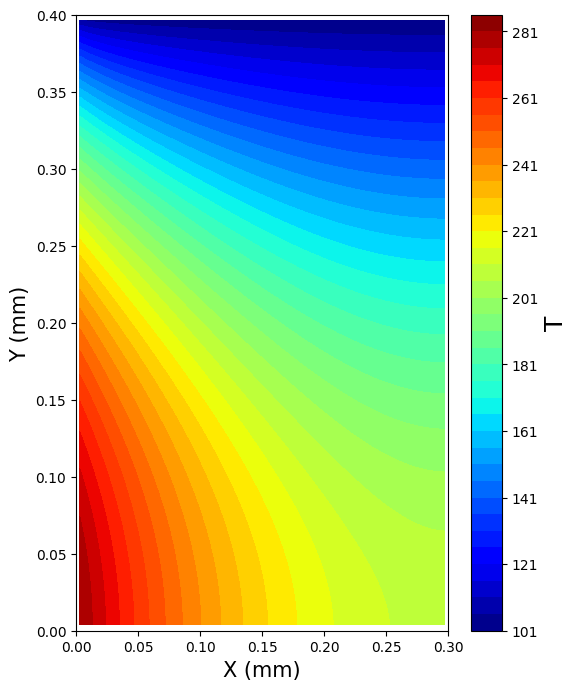

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from matplotlib import cm

cellC = np.ones([nx*ny, 2])
for i in range(len(cellC)):
    cellC[i, 0] = deltax / 2 + (i % nx) * deltax
    cellC[i, 1] = deltay / 2 + (np.floor(i / nx)) * deltay

x = cellC[:, 0]
y = cellC[:, 1]

def plot_contour(Coordx, Coordy, T, minX, maxX, minY, maxY):
    X = np.linspace(minX, maxX, 100)
    Y = np.linspace(minY, maxY, 100)
    X1, Y1 = np.meshgrid(X, Y)
    Z = interpolate.griddata((Coordx, Coordy), T, (X1, Y1), method='cubic')
    fig, ax = plt.subplots(figsize=(6, 8))
    levels = range((int)(T.min()), (int)(T.max()) + 10, 5)
    cset1 = ax.contourf(X1, Y1, Z, levels, cmap=cm.jet)
    ax.set_xlim(minX, maxX)
    ax.set_ylim(minY, maxY)
    ax.set_xlabel("X (mm)", size=15)
    ax.set_ylabel("Y (mm)", size=15)
    cbar = fig.colorbar(cset1)
    cbar.set_label('T', size=18)

# 调用函数
plot_contour(x, y, T, 0, 0.3, 0, 0.4)

In [16]:
len(cellC)

24